In [1]:
import torch,torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import *
from torch.optim import *
from tqdm import tqdm
import wandb
import cv2
PROJECT_NAME = 'Ethereum-Price-Prediction'
device = 'cuda:0'

In [2]:
data = pd.read_csv('./data.csv')

In [3]:
data.iloc[100:]

,Date,Price,Open,High,Low,Vol.,Change %
100,"May 01, 2021","2,944.66","2,772.27","2,951.74","2,753.60",1.51M,6.20%
101,"Apr 30, 2021","2,772.78","2,757.02","2,797.61","2,726.03",1.52M,0.56%
102,"Apr 29, 2021","2,757.36","2,746.51","2,797.52","2,670.35",1.65M,0.39%
103,"Apr 28, 2021","2,746.54","2,665.83","2,759.03","2,562.74",1.74M,3.05%
104,"Apr 27, 2021","2,665.24","2,531.07","2,677.95","2,484.44",1.45M,5.22%
...,...,...,...,...,...,...,...
1974,"Mar 14, 2016",12.5,15.07,15.07,11.4,92.18K,-17.05%
1975,"Mar 13, 2016",15.07,12.92,15.07,12.92,1.30K,16.64%
1976,"Mar 12, 2016",12.92,11.95,13.45,11.95,0.83K,8.12%
1977,"Mar 11, 2016",11.95,11.75,11.95,11.75,0.18K,1.70%


In [4]:
X = data['Date'][100:]

In [5]:
y = data['Price'][100:]

In [6]:
month_labels = {}

In [7]:
idx = -1

In [8]:
for date in X:
    date = date.split(' ')
    if date[0] not in list(month_labels.keys()):
        idx += 1
        month_labels[date[0]] = idx

In [9]:
new_X = []

In [10]:
for date in X:
    date = date.split(' ')
    date[0] = month_labels[date[0]]
    date[1] = int(date[1].replace(',',''))
    date[2] = int(date[2])
    date = int(f'{date[0]}{date[1]}{date[2]}')
    new_X.append(date)

In [11]:
X = torch.from_numpy(np.array(new_X))

In [12]:
new_y = []

In [13]:
for price in y:
    price = float(price.replace(',',''))
    new_y.append(price)

In [14]:
y = torch.from_numpy(np.array(new_y))

In [15]:
class LSTMPredictor(Module):
    def __init__(self,n_hidden=512):
        super().__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = LSTMCell(1,self.n_hidden).to(device)
        self.lstm2 = LSTMCell(self.n_hidden,self.n_hidden).to(device)
        self.linear = Linear(self.n_hidden,1).to(device)
    
    def forward(self,X,future=0):
        outputs = []
        n_samples = X.size(0)
        h_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        h_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        for input_t in X.split(1,dim=1):
            input_t = input_t.to(device)
            h_t = h_t.to(device)
            c_t = c_t.to(device)
            h_t,c_t = self.lstm1(input_t,(h_t,c_t))
            h_t = h_t.to(device)
            c_t = c_t.to(device)
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            output = self.linear(h_t2)
            output = output.to(device)
            outputs.append(output)
        for i in range(future):
            h_t,c_t = self.lstm1(output,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=1)
        return outputs

In [16]:
epochs = 18

In [17]:
batch_size = len(y)

In [18]:
data_input = torch.from_numpy(np.array(y)).view(1,-1)[:3,:-1].float().to(device)
data_target = torch.from_numpy(np.array(y)).view(1,-1)[:3,1:].float().to(device)

In [19]:
model = LSTMPredictor().to(device)
model.to(device)

LSTMPredictor(
  (lstm1): LSTMCell(1, 512)
  (lstm2): LSTMCell(512, 512)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)

In [20]:
criterion = MSELoss()

In [21]:
optimizer = LBFGS(model.parameters(),lr=0.8)

In [22]:
# wandb.init(project=PROJECT_NAME,name='baseline')
# for _ in tqdm(range(epochs)):
#     for idx in range(0,len(y),batch_size):
#         y_batch_input = data_input[idx:idx+batch_size].float().to(device)
#         y_batch_target = data_target[idx:idx+batch_size].float().to(device)
#         torch.cuda.empty_cache()
#         def closure():
#             optimizer.zero_grad()
#             data_input.cuda()
#             data_target.cuda()
#             model.cuda()
#             out = model(data_input.cuda()).cuda()
#             out.cuda()
#             loss = criterion(out,data_target)
#             wandb.log({'loss':loss.item()})
#             loss.backward()
#             return loss
#         optimizer.step(closure)
#         with torch.no_grad():
#             future = 125
#             pred = model(data_input,future=future)
#             loss = criterion(pred[:,:-future],data_target)
#             y = pred.to('cpu').detach().numpy()
#             wandb.log({'Val Loss':loss.item()})
#     plt.figure(figsize=(12,6))
#     n = data_input.shape[1]
#     def draw(y_i,color):
#         plt.plot(np.arange(n),data_target.cpu().view(-1),color)
#         plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
#     draw(y[0],'r')
#     plt.savefig('./preds/img.png')
#     plt.close()
#     wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})
# wandb.finish()

In [23]:
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    OneHotEncoder,
    LabelEncoder,
    Normalizer,
)

In [24]:
pres = [StandardScaler(),RobustScaler(),MinMaxScaler(),MaxAbsScaler(),Normalizer()]

In [25]:
y_old = y

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


  0%|          | 0/18 [00:25<?, ?it/s]


ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

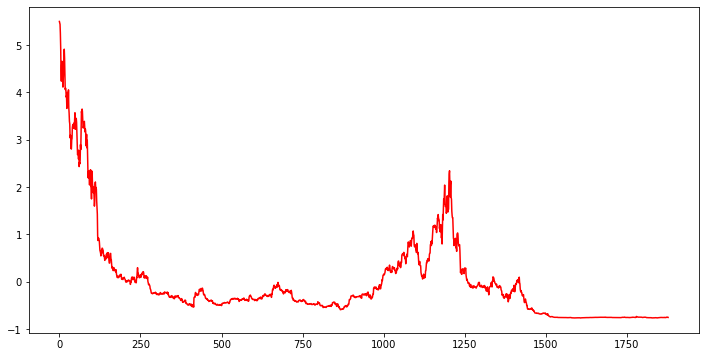

In [26]:
for pre in pres:
    wandb.init(project=PROJECT_NAME,name=f'{pre}')
    y = y_old
    pre.fit(y.reshape(-1,1))
    y = pre.transform(y.reshape(-1,1))
    model = LSTMPredictor().to(device)
    model.to(device)
    criterion = MSELoss()
    optimizer = LBFGS(model.parameters(),lr=0.8)
    data_input = torch.from_numpy(np.array(y)).view(1,-1)[:3,:-1].float().to(device)
    data_target = torch.from_numpy(np.array(y)).view(1,-1)[:3,1:].float().to(device)
    for _ in tqdm(range(epochs)):
        for idx in range(0,len(y),batch_size):
            y_input_batch = data_input[idx:idx+batch_size]
            y_target_batch = data_target[idx:idx+batch_size]
            def closure():
                optimizer.zero_grad()
                preds = model(y_input_batch)
                loss = criterion(preds,y_target_batch)
                wandb.log({'Loss':loss.item()})
                loss.backward()
                return loss
            optimizer.step(closure)
            with torch.no_grad():
                future = 100
                preds = model(data_input,future)
                loss = criterion(preds[:,:-future],data_target)
                wandb.log({'Val Loss':loss.item()})
                test_preds = preds.cpu().detach().numpy()
        plt.figure(figsize=(12,6))
        n = data_input.shape[1]
        def draw(y_i,color):
            plt.plot(np.arange(n),data_target.cpu().view(-1),color)
            plt.plot(np.arange(n,n+future),y_i[n:],color + ':')
        draw(y[0],'r')
        plt.savefig('./preds/img.png')
        plt.close()
        wandb.log({'Img':wandb.Image(cv2.imread('./preds/img.png'))})